In [1]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov
using Revise
using LAR.Node
using LAR.Data
using ProgressMeter
using LinearAlgebra
using Plots

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260


In [133]:
ARorder = 10
n_samples = 100
tau = 1.0
coefs, reals = generateAR(n_samples, ARorder)
obs = [x[1] + sqrt(tau)*randn() for x in reals]
reals = [x[1] for x in reals];

100-element Array{Float64,1}:
 -0.13374903573334884
 -1.3939129914210908
 -0.5878128050078815
  0.3049932493236948
 -0.7667748865417107
  0.32252196087388807
  0.5770297558016493
  1.1151292964681077
  0.8431521339197423
  1.709929392871294
  1.9701004363294203
  0.9237355539996046
  2.1925999615964966
  ⋮
 -2.7685473740147737
  4.184840372164936
 -5.734108068273487
  4.097429286714939
 -3.5181986782543255
 -0.4825940720443765
  0.6303516018962579
 -1.9619849753109517
  1.6531300442790748
 -4.3146647230936415
  4.579337020787891
 -6.251913037767798

In [134]:
fg = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                               placeholder(:v_x_0, dims=(ARorder, ARorder)))

@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                             placeholder(:v_θ, dims=(ARorder, ARorder)))

@RV γ ~ Gamma(placeholder(:a), placeholder(:b))

# Transition and observation model
x = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)

c = zeros(ARorder); c[1] = 1.0

x_i_min = x_0
for i in 1:n_samples
    global x_i_min
    @RV x[i] ~ Autoregressive(θ, x_i_min, γ)

    @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), inv(tau))

    # Data placeholder
    placeholder(y[i], :y, index=i)

    # Reset state for next step
    x_i_min = x[i]
end

In [135]:
q = PosteriorFactorization(x_0, x, γ, θ, ids=[:X0 :X :Γ :Θ])
algo = variationalAlgorithm(q, free_energy=true)
src_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(src_code))

freeEnergy (generic function with 1 method)

In [127]:
# Initial posterior factors
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:θ] = vague(GaussianMeanVariance, ARorder)
marginals[:γ] = ProbabilityDistribution(Gamma, a=1.0, b=1.0)
for i in 0:n_samples
    marginals[:x_*i] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
end

In [137]:
data = Dict(:y => obs, :m_x_0 => zeros(ARorder), :v_x_0 => diagm(ones(ARorder)),
                :m_θ => zeros(ARorder), :v_θ => diagm(ones(ARorder)),
                :a => 1.0, :b => 1.0, :tau=>tau)

n_its = 20
fe = Vector{Float64}(undef, n_its)
# Run algorithm
@showprogress for i in 1:n_its
    stepX0!(data, marginals)
    stepX!(data, marginals)
    stepΓ!(data, marginals)
    stepΘ!(data, marginals)
    fe[i] = freeEnergy(data, marginals)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [139]:
m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
insert!(v_x, 1, unsafeCov(marginals[:x_0])[1]);

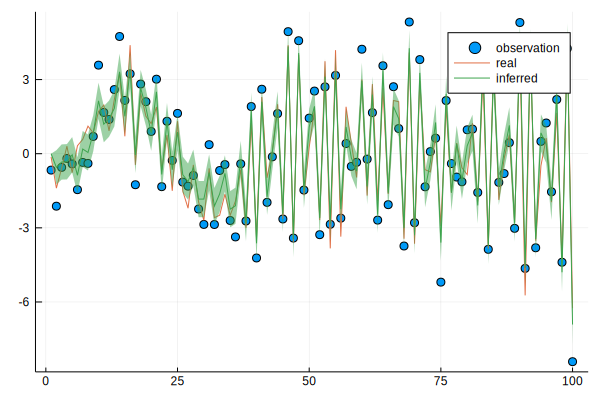

In [140]:
scatter(obs, label="observation")
plot!(reals, label="real")
plot!(m_x, ribbon=sqrt.(v_x), label="inferred")

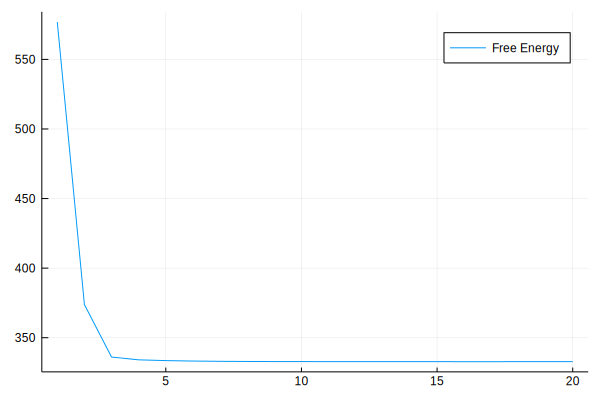

In [141]:
plot(fe, label="Free Energy")